### HEB 12 Month Forecast
- Author: Amanda LaForest
- Date: September 17, 2025
- Most Recent Update: Used Actual HEB Spend Per Their Databricks Systems Tables
- Model: Meta's Prophet Time Series forecasting model
  - **Rationale**: Specifically made for business time-series data, published in 2017, incorporates seasonality and holidays, alternative to traditional ARIMA models

In [0]:
!pip install prophet

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# Replace with your table/schema
df = (spark.sql("""
SELECT
  YearMonth,
  -- 5 yr forecast line includes trend line for 1.5% growth rate + 4.6m in planned migrations
  ( ((269258.23+77700)*1.02) * POWER(1.015, (CAST(SUBSTR(YearMonth, 1, 4) AS INTEGER) - 2022) * 12 + (CAST(SUBSTR(YearMonth, 6, 2) AS INTEGER) - 1))) AS five_yr_forecast_line,
  SUM(u.usage_quantity * lp.pricing.default) AS total_list_usd,
  SUM(u.usage_quantity * lp.pricing.default) * 0.58 AS total_heb_usd
FROM (
  SELECT
    date_format(date_trunc('month', u.usage_date), 'yyyy-MM') AS YearMonth,
    u.usage_quantity,
    u.sku_name,
    u.cloud,
    u.usage_unit,
    u.usage_end_time
  FROM system.billing.usage u
) u
LEFT JOIN system.billing.list_prices lp
  ON u.sku_name = lp.sku_name
  AND u.cloud = lp.cloud
  AND u.usage_unit = lp.usage_unit
  AND u.usage_end_time >= lp.price_start_time
  AND (lp.price_end_time IS NULL OR u.usage_end_time < lp.price_end_time)
  AND lp.currency_code = 'USD'
GROUP BY YearMonth
HAVING SUM(u.usage_quantity * lp.pricing.default) * 0.58 >= 600
ORDER BY YearMonth
""").toPandas())

# Prophet needs datetime + float
df["ds"] = pd.to_datetime(df["YearMonth"])
df["y"] = df["total_heb_usd"].astype(float)

# Make sure it's sorted
df = df.sort_values('ds')

#df.head(10)

In [0]:
df.head(10)

,YearMonth,five_yr_forecast_line,total_list_usd,total_gap_usd,ds,y
0,2023-08,469604.411549,145721.002405,84518.181395,2023-08-01,84518.181395
1,2023-09,476648.477722,879690.560502,510220.525091,2023-09-01,510220.525091
2,2023-10,483798.204888,713782.683054,413993.956171,2023-10-01,413993.956171
3,2023-11,491055.177961,818105.778295,474501.351411,2023-11-01,474501.351411
4,2023-12,498421.005631,810967.778698,470361.311645,2023-12-01,470361.311645
5,2024-01,505897.320715,1151191.552007,667691.100164,2024-01-01,667691.100164
6,2024-02,513485.780526,1314109.384092,762183.442773,2024-02-01,762183.442773
7,2024-03,521188.067234,1312969.599510,761522.367716,2024-03-01,761522.367716
8,2024-04,529005.888242,1151834.361748,668063.929814,2024-04-01,668063.929814
9,2024-05,536940.976566,1325647.065978,768875.298267,2024-05-01,768875.298267


In [0]:
# Monthly series: smooth with a 3-month moving average for model fitting
# NOTE: Filtering on only August 2024 and before for forecasting
df_smooth = df #[df['ds']>'2023-08-01'].copy()
df_smooth["y"] = df_smooth["y"].rolling(3, min_periods=1, center=True).mean()

# Cap extreme spikes (winsorize at 1st/99th percentile)
q1, q99 = df_smooth["y"].quantile([0.01, 0.99])
df_smooth["y"] = df_smooth["y"].clip(q1, q99)

m = Prophet(
    yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False,
    growth="linear",
    seasonality_mode="multiplicative",     # try "additive" if level is stable
    changepoint_prior_scale=0.01,          # ↓ smoother trend
    seasonality_prior_scale=.1,           # ↓ gentler seasonality
    n_changepoints=10,                     # fewer kinks
    changepoint_range=0.8,                 # don't overfit the last tail
    #uncertainty_samples=0                  # deterministic forecast line
)
m.fit(df_smooth)  # df has columns ds (datetime) and y (float)

future = m.make_future_dataframe(periods=12, freq="MS")
forecast = m.predict(future)
#display(forecast)

20:16:00 - cmdstanpy - INFO - Chain [1] start processing
20:16:00 - cmdstanpy - INFO - Chain [1] done processing


In [0]:
# Calculate difference between actual and forecast
df['yhat'] = forecast['yhat']
df['difference'] = df['y'] - forecast['yhat']

df1 = df.merge(forecast[['ds','yhat']],
         how='outer',
         on='ds',
        )
#df1['ds'] =df1['ds'].dt.to_period('M')
#df1['YearMonth'] = df1['ds']

# Filter before Oct 2025
#df = df[df['ds']<'2025-10-01']

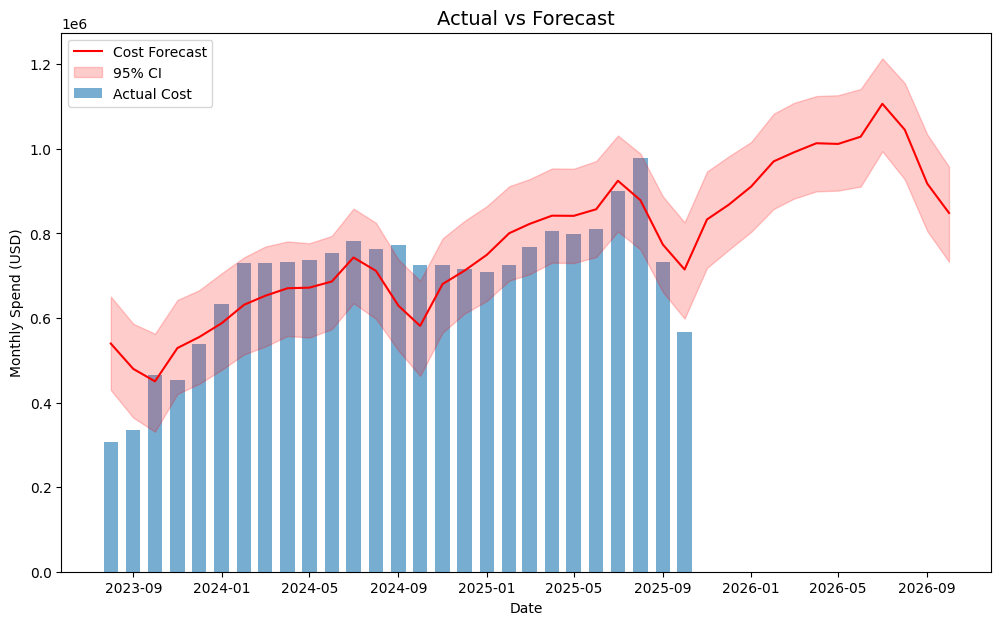

In [0]:
# df = your original data with ds (datetime) and y (numeric)
# forecast = Prophet output with ds, yhat, yhat_lower, yhat_upper

fig, ax = plt.subplots(figsize=(12,7)) 

# 1) Original data as bar chart
ax.bar(df["ds"], df["y"], width=20, alpha=0.6, label="Actual Cost")

# 2) Forecast as line
ax.plot(forecast["ds"], forecast["yhat"], color="red", label="Cost Forecast")

# 3) Confidence interval (optional)
ax.fill_between(forecast["ds"],
                forecast["yhat_lower"],
                forecast["yhat_upper"],
                color="red", alpha=0.2, label="95% CI")

# 4) Styling
ax.set_title("Actual vs Forecast", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Monthly Spend (USD)")
ax.legend(loc="upper left")

plt.show()

In [0]:
print('PRE OPTIMIZATION')

# Average Actual vs. Expected 6 months prior to intervention (optimization)
print('9 Months Pre-Intervention:', round(df[(df['ds']<'2024-09-01') & (df['ds']>='2023-12-01')]['difference'].mean(),2),'spent per month OVER predicted based on forecasting model (Meta Prophet)\n')

print('POST OPTIMIZATION')

# Average Actual vs. Expected 6 months post-intervention
print('9 Months Post-Intervention', round(df[(df['ds']>='2024-09-01') & (df['ds']>='2023-12-01')]['difference'].mean(),2),'spent per month UNDER predicted based on forecasting model (Meta Prophet)')

print('9 Months Post-Intervention', abs(round(df[(df['ds']>='2024-09-01') & (df['ds']<='2025-05-01')]['difference'].sum(),2)),'estimated total savings')

# Other Useful Quick Checks
#df[(df['ds']<'2024-09-01') & (df['ds']>='2023-12-01')].reset_index()
#df[(df['ds']>='2024-09-01') & (df['ds']<='2025-05-01')].reset_index()
#forecast.head(2)
#df1

PRE OPTIMIZATION
9 Months Pre-Intervention: 54775.84 spent per month OVER predicted based on forecasting model (Meta Prophet)

POST OPTIMIZATION
9 Months Post-Intervention -5272.3 spent per month UNDER predicted based on forecasting model (Meta Prophet)
9 Months Post-Intervention 85723.91 estimated total savings


In [0]:
spark_df = spark.createDataFrame(df1)
spark_df.write.mode("overwrite").saveAsTable("main.billing_forecast_demo.forecast_next_12_period_v3")